In [ ]:

import pandas as pd
import numpy as np

In [2]:
# Load the uploaded CSV files
member_info_path = r"C:\Users\MdMuntasirulHoque\OneDrive - ADA Global\Desktop\Certificate\Data Challenge Insightin Technology 2025 (1)\Data Challenge Insightin Technology 2025\analytics\MemberInfo.csv"
record_path = r"C:\Users\MdMuntasirulHoque\OneDrive - ADA Global\Desktop\Certificate\Data Challenge Insightin Technology 2025 (1)\Data Challenge Insightin Technology 2025\analytics\Record.csv"

In [3]:
# Read the data into DataFrames
member_df = pd.read_csv(member_info_path)
record_df = pd.read_csv(record_path)

In [4]:
# Display the first few rows of each DataFrame
member_df.head(), record_df.head()

(   MEMBER_ID
 0      16719
 1      85454
 2      81899
 3      91194
 4      87518,
    MEMBER_ID SURVEY_DATE  COMP_FORM DATE_OF_BIRTH  GENDER  RACE  \
 0          6   4/11/2019        4.0     23-Sep-59     2.0   1.0   
 1          8    3/8/2019        1.0      3-May-52     2.0   NaN   
 2         11   5/13/2019        1.0     18-Mar-65     2.0   1.0   
 3         11   12/5/2019        1.0     18-Mar-65     2.0   1.0   
 4         12  10/22/2019        1.0      6-Aug-59     2.0   1.0   
 
    HISPANIC_LATIO  LANGUAGE HEIGHT WEIGHT  ...  Q30_CARE_PAST_30_1  \
 0             1.0       1.0     64    117  ...                 1.0   
 1             NaN       1.0    NaN    NaN  ...                 1.0   
 2             1.0       1.0    5'1    144  ...                 1.0   
 3             1.0       1.0    NaN    NaN  ...                 NaN   
 4             1.0       1.0    NaN    NaN  ...                 1.0   
 
    Q30_CARE_PAST_30_2  Q30_CARE_PAST_30_3  Q30_CARE_PAST_30_4  \
 0         

In [5]:
# Filter records for members in MemberInfo
target_records = record_df[record_df["MEMBER_ID"].isin(member_df["MEMBER_ID"])].copy()

# Convert SURVEY_DATE to datetime for sorting
target_records["SURVEY_DATE"] = pd.to_datetime(target_records["SURVEY_DATE"], errors='coerce')

# Keep only the latest survey record per member
latest_records = target_records.sort_values("SURVEY_DATE").drop_duplicates("MEMBER_ID", keep="last")

# Check value counts of Q29_ANNUAL_SCRN
screening_counts = latest_records["Q29_ANNUAL_SCRN"].value_counts(dropna=False)

# Calculate completion rate (2 = Yes, 1 = No)
completed = screening_counts.get(2, 0)
total_with_response = screening_counts.get(1, 0) + completed
completion_rate = completed / total_with_response if total_with_response > 0 else None

screening_counts, completion_rate


(Q29_ANNUAL_SCRN
 2.0    17981
 1.0     5152
 NaN     3955
 Name: count, dtype: int64,
 np.float64(0.7772878571737345))

```python
Results for (a) & (b)
We filtered the records and retained only the latest survey per member from the target list.
Completed (Q29_ANNUAL_SCRN = 2): 17,981
Not Completed (Q29_ANNUAL_SCRN = 1): 5,152
Missing/Blank: 3,955
Completion Rate (based on available responses):
~77.73%
So about 78% of the target members who responded did complete their annual screening.


```

In [6]:
# Select the latest records for analysis
df = latest_records.copy()

# Basic data overview: missing values
missing_summary = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_summary / len(df)) * 100
missing_df = pd.DataFrame({
    "Missing Values": missing_summary,
    "Missing (%)": missing_percent
})

# Basic stats for numerical columns
numeric_cols = df.select_dtypes(include=['number']).columns
numerical_summary = df[numeric_cols].describe().T

missing_df.head(10), numerical_summary.head(10)


(                   Missing Values  Missing (%)
 Q8T_FOLLOW_UP_2             27087    99.996308
 Q8T_FOLLOW_UP_7             27068    99.926167
 Q8T_FOLLOW_UP_5             27063    99.907708
 Q8T_FOLLOW_UP_3             27046    99.844950
 Q5_HEALTH_COND_7            27026    99.771116
 Q8T_FOLLOW_UP_4             27015    99.730508
 Q6_WELLBEING_4              27004    99.689900
 Q8T_FOLLOW_UP_6             26935    99.435174
 Q5_HEALTH_COND_12           26808    98.966332
 Q8T_FOLLOW_UP_1             26699    98.563940,
                     count          mean           std  min       25%      50%  \
 MEMBER_ID         27088.0  44250.612338  28111.826491  6.0  19161.75  39947.5   
 COMP_FORM         26946.0      3.081793      1.363900  1.0      1.00      4.0   
 GENDER            25975.0      1.639461      0.480166  1.0      1.00      2.0   
 RACE              23766.0      2.145965      2.065992  1.0      1.00      1.0   
 HISPANIC_LATIO    23813.0      1.181959      0.385819  1.0  

here’s the deal with step (c): data cleaning.

```python

Missing Value Summary:
There are some columns basically 100% empty — like:
Q8T_FOLLOW_UP_1 to Q8T_FOLLOW_UP_7
Q5_HEALTH_COND_7 and Q5_HEALTH_COND_12
Q6_WELLBEING_4
These are useless for modeling — we’ll drop them.

Other Missingness:
Demographic fields like GENDER, RACE, HISPANIC_LATIO, etc. have ~10–15% missing.
Some survey questions have missing values, but they’re still informative — we’ll impute these later (likely with mode or most frequent category).

Cleaning Plan: 
Drop columns with >95% missing.Impute missing values for categorical variables using mode (most common).

Drop records that still have missing target values (Q29_ANNUAL_SCRN).

```

In [7]:
# Step 1: Drop columns with more than 95% missing values
cols_to_drop = missing_df[missing_df["Missing (%)"] > 95].index.tolist()
df_cleaned = df.drop(columns=cols_to_drop)

# Step 2: Drop rows with missing target
df_cleaned = df_cleaned[df_cleaned["Q29_ANNUAL_SCRN"].notnull()]

# Step 3: Fill missing values with mode (categorical imputation)
for col in df_cleaned.columns:
    if df_cleaned[col].isnull().sum() > 0:
        mode_value = df_cleaned[col].mode(dropna=True)
        if not mode_value.empty:
            df_cleaned[col].fillna(mode_value[0], inplace=True)

# Verify remaining missing values
remaining_missing = df_cleaned.isnull().sum().sum()

df_cleaned.shape, remaining_missing


C:\Users\MdMuntasirulHoque\AppData\Local\Temp\ipykernel_17204\3016163557.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(mode_value[0], inplace=True)


((23133, 80), np.int64(0))

In [8]:
# Drop columns with more than 95% missing values
cols_to_drop = df.columns[df.isnull().mean() > 0.95]
df_cleaned = df.drop(columns=cols_to_drop)

# Drop rows where the target variable is missing
df_cleaned = df_cleaned[df_cleaned["Q29_ANNUAL_SCRN"].notnull()]

# Fill missing values with mode for categorical features
for col in df_cleaned.columns:
    if df_cleaned[col].isnull().sum() > 0:
        mode_val = df_cleaned[col].mode().iloc[0]
        df_cleaned[col].fillna(mode_val, inplace=True)

# Check the result
print("Remaining missing values:", df_cleaned.isnull().sum().sum())


C:\Users\MdMuntasirulHoque\AppData\Local\Temp\ipykernel_17204\860745560.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(mode_val, inplace=True)


Remaining missing values: 0


In [10]:
!pip install xgboost


  Using cached xgboost-3.0.2-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.2-py3-none-win_amd64.whl (150.0 MB)


Modeling Pipeline Outline:

Convert Q29_ANNUAL_SCRN to binary:

    1 (did not complete) → 0,
    2 (completed) → 1.

Label encode categorical columns.

    Train/test split (80/20).

Train a few models:

    Logistic Regression (baseline)

    Random Forest (non-linear)

    XGBoost (if available)

Evaluate with:

    Accuracy

    Precision, Recall, F1

    ROC-AUC

Feature importance extraction from the best model.



In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Step 1: Binary encode the target
df_cleaned["TARGET"] = df_cleaned["Q29_ANNUAL_SCRN"].map({1: 0, 2: 1})

# Step 2: Drop columns that won't help
df_model = df_cleaned.drop(columns=["MEMBER_ID", "SURVEY_DATE", "Q29_ANNUAL_SCRN"])

# Step 3: Label encode all categorical columns
for col in df_model.columns:
    if df_model[col].dtype == "object":
        df_model[col] = LabelEncoder().fit_transform(df_model[col].astype(str))

# Step 4: Split data
X = df_model.drop(columns=["TARGET"])
y = df_model["TARGET"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train models
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

models = {
    "Logistic Regression": lr,
    "Random Forest": rf,
    "XGBoost": xgb_clf
}

# Step 6: Fit and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probas = model.predict_proba(X_test)[:, 1]
    print(f"\n{name}")
    print(classification_report(y_test, preds))
    print("ROC AUC Score:", roc_auc_score(y_test, probas))


c:\Users\MdMuntasirulHoque\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression
              precision    recall  f1-score   support

           0       0.61      0.13      0.21      1078
           1       0.79      0.97      0.87      3549

    accuracy                           0.78      4627
   macro avg       0.70      0.55      0.54      4627
weighted avg       0.75      0.78      0.72      4627

ROC AUC Score: 0.6890866851620384

Random Forest
              precision    recall  f1-score   support

           0       0.59      0.13      0.21      1078
           1       0.79      0.97      0.87      3549

    accuracy                           0.78      4627
   macro avg       0.69      0.55      0.54      4627
weighted avg       0.74      0.78      0.72      4627

ROC AUC Score: 0.6792461855256203


c:\Users\MdMuntasirulHoque\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [03:02:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost
              precision    recall  f1-score   support

           0       0.51      0.19      0.28      1078
           1       0.79      0.94      0.86      3549

    accuracy                           0.77      4627
   macro avg       0.65      0.57      0.57      4627
weighted avg       0.73      0.77      0.73      4627

ROC AUC Score: 0.6697954060591423


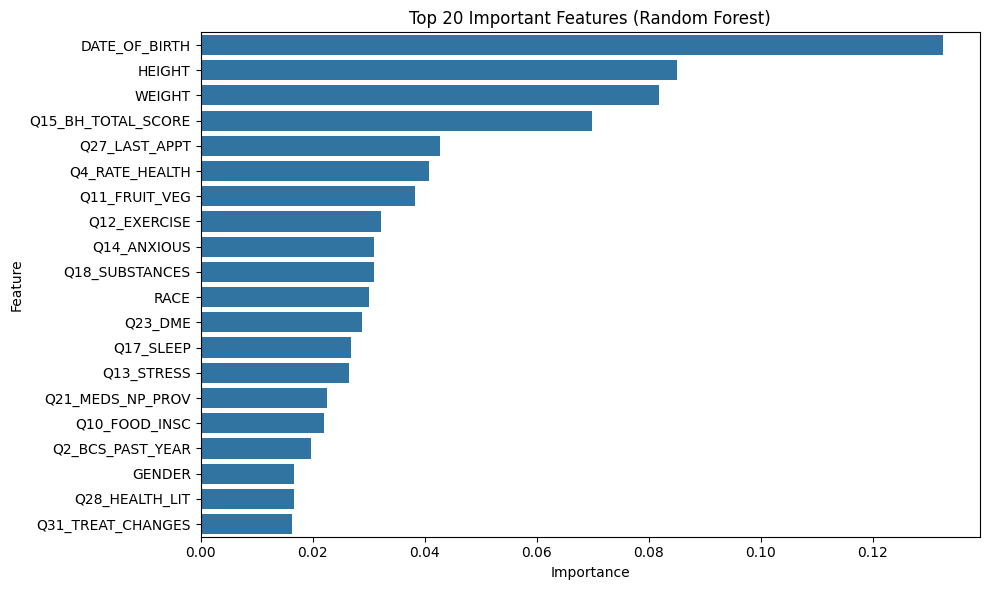

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Random Forest feature importances
importances = rf.feature_importances_
feat_names = X.columns
feat_df = pd.DataFrame({"Feature": feat_names, "Importance": importances})
feat_df = feat_df.sort_values("Importance", ascending=False).head(20)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feat_df)
plt.title("Top 20 Important Features (Random Forest)")
plt.tight_layout()
plt.show()
